## Setup

In [1]:
import sys
sys.path.append('../')
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm

from src.generateIP import generate_knapsack_ip
from src.IP import *
from src.LTNN import *
from src.data_loader import *
from src.DDPG import *
from src.env import *
from src.train import *

import time
import torch
import torch.nn as nn
import torch.optim as optim


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

N, K = 16, 2
num_samples = 5000
buffer_size = 6000
random_seed = 0
minimal_size = 512
num_cuts = 1
batch_size = 512

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)



file_paths = [f"../data/knapsack_train/knapsack_ip_train_{i}.pt" for i in range(num_samples)]
dataset = KnapsackDataset(file_paths)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

env = IPenv(file_paths=file_paths, num_cons=N+K+2*N*K, num_vars=N*K, num_cuts=num_cuts, device=device, problem_type="knapsack")


In [3]:
agent = DDPG(N=N, 
             K=K, 
             num_cuts=num_cuts, 
             hidden_channels_actor=[256,256], 
             hidden_channels_critic=[64,32], 
             activation="StepSigmoid", 
             squeeze="Sigmoid", 
             use_bn=False, 
             sigma=0.01, 
             actor_lr=3e-4, 
             critic_lr=3e-3, 
             tau=0.01, 
             gamma=0.9, 
             device=device, 
             problem_type="knapsack")

replay_buffer = ReplayBuffer(buffer_size)
agent.actor

Actor(
  (ReLU): ReLU()
  (Sigmoid): Sigmoid()
  (MaskedSigmoid): MaskedSigmoid()
  (hidden_layers): ModuleList(
    (0): Linear(in_features=18, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (bn_output): BatchNorm1d(82, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output_layer): Linear(in_features=256, out_features=82, bias=True)
  (activation): StepSigmoid()
  (squeeze): Sigmoid()
)

## Training

In [4]:
return_list = train(env=env, agent=agent, num_samples=num_samples, replay_buffer=replay_buffer, minimal_size=minimal_size, batch_size=batch_size, epochs=5)

Epoch 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-28


Epoch 5: 100%|██████████| 5000/5000 [06:08<00:00, 13.56it/s, Return=-30.5, Moving Avg Return=-5.4] 


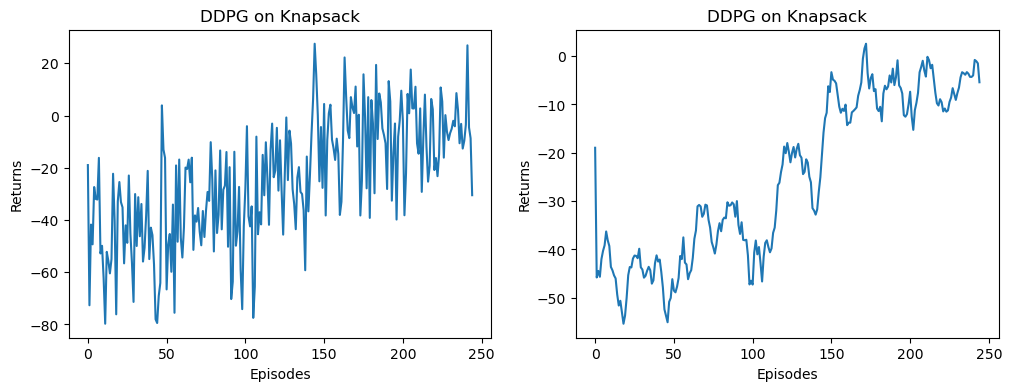

In [5]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on Knapsack')
plt.subplot(1,2,2)
mv_return = moving_average(return_list, min(10, len(return_list)))
episodes_list = list(range(len(mv_return)))
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on Knapsack')
plt.show()

In [6]:
test_size = 1000  
test_file_paths = [f"../data/knapsack_test/knapsack_ip_test_{i}.pt" for i in range(test_size)]
after_treesize = []

for i in tqdm(range(test_size)):
    loaded_dict = torch.load(test_file_paths[i])
    ip_tensor_i = loaded_dict['ip_tensor']
    treesize_i = loaded_dict['treesize']

    # Processing with LT agent generated Chvatal Cut
    ip_object_i = vector_to_ip(ip_tensor_i, N+K+2*N*K, N*K, problem_type="knapsack")
    u = agent.actor(torch.cat((ip_tensor_i[0:16], ip_tensor_i[-82:-80]), dim=0).cuda()).cpu().detach().numpy()
    ip_object_i.add_sequence_chvatal_cut(u, 1)
    ip_object_i.optimize()
    after_treesize.append(ip_object_i.treesize)

print(f"Average Tree Size after 1 LT agent generated Chvatal Cut (on unseen test set of size 1000): {np.mean(after_treesize)}")

100%|██████████| 1000/1000 [00:52<00:00, 19.21it/s]

Average Tree Size after 1 LT agent generated Chvatal Cut (on unseen test set of size 1000): 245.244


In [7]:
torch.save(agent.actor.state_dict(), "../models/LT_actor.pt")

## Inference time comparison

In [8]:
test_instances_cuda = []
test_LP_models = []
for i in tqdm(range(test_size)):
    loaded_dict = torch.load(test_file_paths[i])
    ip_tensor_i = loaded_dict['ip_tensor']
    treesize_i = loaded_dict['treesize']
    ip_vector = torch.cat((ip_tensor_i[0:16],ip_tensor_i[-82:-80])).view(1,-1)
    test_instances_cuda.append(ip_vector)
    ip_object_i = vector_to_ip(ip_tensor_i, N+K+2*N*K, N*K, problem_type="knapsack")
    A, c, b = ip_object_i.A[:18,:], ip_object_i.c, ip_object_i.b[:18]
    ipmodel = gp.Model()
    ipmodel.setParam("OutputFlag", 0)
    x = ipmodel.addVars(A.shape[1], vtype=GRB.CONTINUOUS, name="x")
    ipmodel.setObjective(sum(c[i] * x[i] for i in range(A.shape[1])), GRB.MAXIMIZE)
    ipmodel.addConstrs((gp.quicksum(A[i, j] * x[j] for j in range(A.shape[1])) <= b[i] for i in range(A.shape[0])), name="cons")
    ipmodel.update()
    test_LP_models.append(ipmodel)
test_instance_cuda = torch.cat(test_instances_cuda).cuda()

100%|██████████| 1000/1000 [00:54<00:00, 18.22it/s]


In [9]:
time1 = time.time()
for i in range(100):
    agent.actor(test_instance_cuda)
time2 = time.time()
print(f"Time taken by NNs to generate cuts for 1000 instances (on GPU): {(time2-time1)}")

Time taken by NNs to generate cuts for 1000 instances (on GPU): 0.021999120712280273


In [10]:
time3 = time.time()
for i in range(100):
    for j in range(len(test_LP_models)):
        test_LP_models[j].optimize()
time4 = time.time()
print(f"Time taken by Gurobi to solve 1000 LPs: {(time4-time3)}")

Time taken by Gurobi to solve 1000 LPs: 4.18733549118042


In [11]:
test_instance_cpu = test_instance_cuda.cpu()
cpu_actor = agent.actor.cpu()

In [12]:
time5 = time.time()
for i in range(100):
    cpu_actor(test_instance_cpu)
time6 = time.time()
print(f"Time taken by NNs to generate cuts for 1000 instances (on CPU): {(time6-time5)}")

Time taken by NNs to generate cuts for 1000 instances (on CPU): 0.16362333297729492
